In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split


In [4]:
df = pd.read_csv("/Users/admin/Downloads/parklane_edited.csv", index_col='timestamp')

### This notebook focus will be on predicting ch_sysef using various features and some selections of models

In [5]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=0) & (df['pchwp_1_kw'] <=25)]
#df = df[(df['pchwp_2_kw'] >=0) & (df['pchwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] >= 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] >= 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >=0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=0) & (df['sys_cl']<=600)]
df = df[(df['sys_hr']>=0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>=0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.3) & (df['ch_sysef']<=0.8)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(fil_df.median())

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']

/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_10516/3650555903.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_10516/3650555903.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']


In [6]:
fil_df['cal_ch_ef'] = (fil_df['ch_1_kwe'] + fil_df['ch_2_kwe'] + fil_df['pchwp_1_kw'] + fil_df['pchwp_2_kw'] + fil_df['cwp_1_kw'] + fil_df['cwp_2_kw'] + fil_df['ct_1_kw'] + fil_df['ct_2_kw']) / fil_df['sys_cl']
fil_df[['cal_ch_ef', 'ch_sysef']].head(10)

/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_10516/3530322637.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fil_df['cal_ch_ef'] = (fil_df['ch_1_kwe'] + fil_df['ch_2_kwe'] + fil_df['pchwp_1_kw'] + fil_df['pchwp_2_kw'] + fil_df['cwp_1_kw'] + fil_df['cwp_2_kw'] + fil_df['ct_1_kw'] + fil_df['ct_2_kw']) / fil_df['sys_cl']


,cal_ch_ef,ch_sysef
timestamp,,
12/3/23 10:35,0.346126,0.387167
12/3/23 10:36,0.276760,0.308619
12/3/23 10:37,0.353557,0.391576
12/3/23 10:38,0.503881,0.550531
12/3/23 10:39,0.435786,0.467190
12/3/23 10:40,0.377864,0.405483
12/3/23 10:41,0.376205,0.404026
12/3/23 10:42,0.749519,0.776193
12/3/23 10:43,0.412917,0.430923


In [7]:
# selecting related features only
ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

ch_sysef_df.head(5)

,ch_sysef,lift,sys_cl,ct_tot_kw
timestamp,,,,
12/3/23 10:35,0.387167,7.367701,127.538132,3.508719
12/3/23 10:36,0.308619,7.805637,152.515945,3.477781
12/3/23 10:37,0.391576,8.073826,126.885735,7.184000
12/3/23 10:38,0.550531,8.440350,107.953125,7.088001
12/3/23 10:39,0.467190,9.664524,155.478806,7.152000


/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

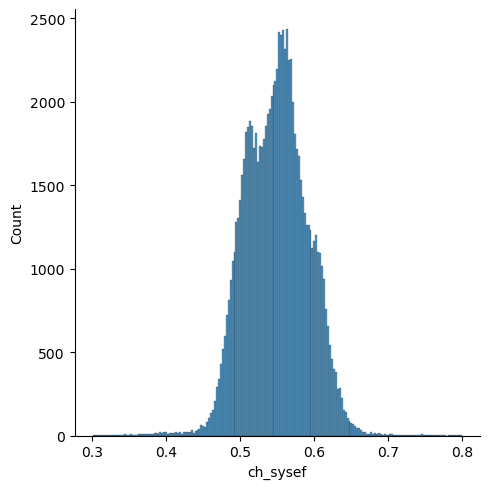

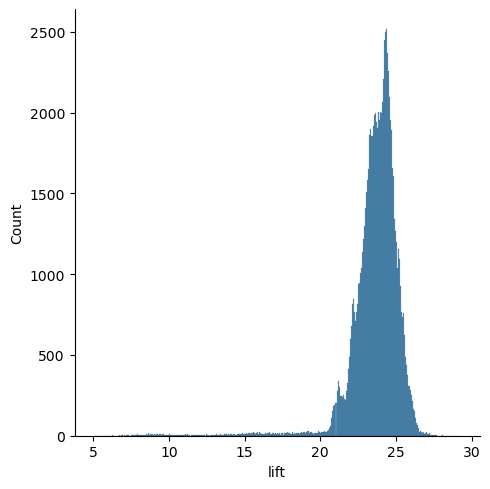

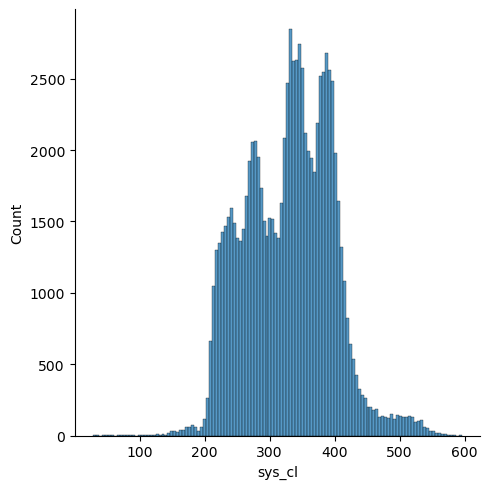

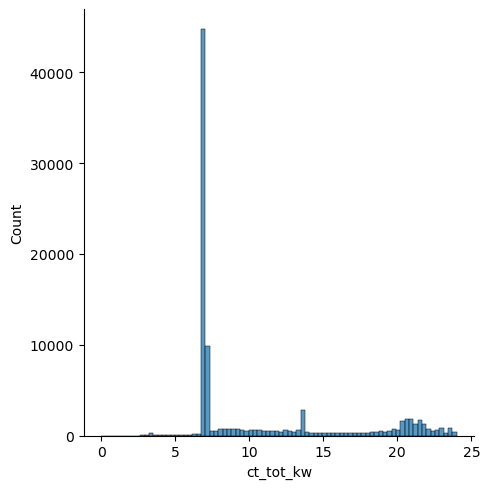

In [8]:
# distribution
sns.displot(ch_sysef_df, x="ch_sysef")
sns.displot(ch_sysef_df, x="lift")
sns.displot(ch_sysef_df, x="sys_cl")
sns.displot(ch_sysef_df, x="ct_tot_kw")

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

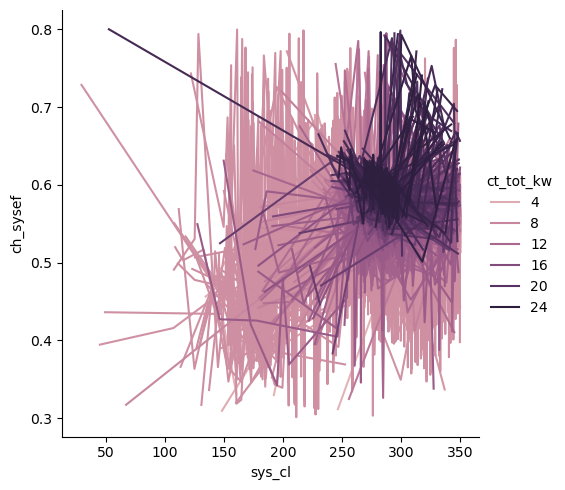

In [9]:
sns.relplot(
    data=ch_sysef_df[ch_sysef_df['sys_cl']<=350], kind="line",
    x="sys_cl", y="ch_sysef",
    hue="ct_tot_kw"
)


## Experiment

In [10]:
# train_test split
X = ch_sysef_df[['lift', 'sys_cl', 'ct_tot_kw']]
y = ch_sysef_df[['ch_sysef']]
y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

timestamp,12/3/23 10:35,12/3/23 10:36,12/3/23 10:37,12/3/23 10:38,12/3/23 10:39,12/3/23 10:40,12/3/23 10:41,12/3/23 10:42,12/3/23 10:43,12/3/23 10:44,...,23/3/23 20:01,23/3/23 20:02,23/3/23 20:03,23/3/23 20:04,23/3/23 20:05,23/3/23 20:06,23/3/23 20:07,23/3/23 20:08,23/3/23 20:09,23/3/23 20:10
ch_sysef,0.387167,0.308619,0.391576,0.550531,0.46719,0.405483,0.404026,0.776193,0.430923,0.511065,...,0.553528,0.557108,0.562911,0.557318,0.552821,0.554524,0.545478,0.554409,0.560558,0.560833


### Random Forest Regressor

In [11]:
no_of_trees = [100, 500]
min_samples_splits = [500, 1000] # maybe remove 5000 & 10000

parameter_grid = {
    'max_depth': no_of_trees,
    'min_samples_split': min_samples_splits
}

grid_search_3feat = GridSearchCV(
    estimator= RandomForestRegressor(),
    param_grid=parameter_grid,
    cv=3
)

regr = RandomForestRegressor()
grid_search_3feat.fit(X_train, y_train)

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
grid_search_3feat.best_params_

{'max_depth': 100, 'min_samples_split': 500}

In [ ]:
X_test.iloc[105]

lift          21.981480
sys_cl       226.226044
ct_tot_kw      7.056000
Name: 12/3/23 18:57, dtype: float64

In [ ]:
y_test.iloc[100]

ch_sysef    0.507318
Name: 18/2/23 16:22, dtype: float64

In [ ]:
grid_search_3feat.predict([[24.013, 350, 7.8]])

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.55967814])

In [ ]:
y_pred = grid_search_3feat.predict(X_test)
root_mean_squared_error(y_test, y_pred) * 100

NameError: name 'grid_search_3feat' is not defined

In [ ]:
# simulate lift: 22-26, cl: 350 above, ct_tot_kw:7, 7.5, ...
lifts = [22, 23, 24, 25, 26]
cls = [250, 350, 400, 450]
ct_tot_kw = [7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5 ,12]
res = []

i = 0
for lift in lifts:
    for cl in cls:
        for ct in ct_tot_kw:
            temp_res = []
            temp_res.append(lift)
            temp_res.append(cl)
            temp_res.append(ct)
            temp_res.append(grid_search_3feat.predict([[lift, cl, ct]])[0])
            
            res.append(temp_res)

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaco

In [ ]:
print(res)

[[22, 250, 7, 0.5136148099701584], [22, 250, 7.5, 0.5293216536496369], [22, 250, 8, 0.5314273937876783], [22, 250, 8.5, 0.537133912082207], [22, 250, 9, 0.5484653384835309], [22, 250, 9.5, 0.5492992835189129], [22, 250, 10, 0.5492992835189129], [22, 250, 10.5, 0.5493792640619456], [22, 250, 11, 0.5493792640619456], [22, 250, 11.5, 0.5493792640619456], [22, 250, 12, 0.5493792640619456], [22, 350, 7, 0.5531230094221641], [22, 350, 7.5, 0.5602439427355236], [22, 350, 8, 0.5606616873166383], [22, 350, 8.5, 0.5635481686572504], [22, 350, 9, 0.5727043982887217], [22, 350, 9.5, 0.5731488387504315], [22, 350, 10, 0.5730756972898717], [22, 350, 10.5, 0.5729914431589044], [22, 350, 11, 0.5718608554014236], [22, 350, 11.5, 0.5681424434957173], [22, 350, 12, 0.5677041469644748], [22, 400, 7, 0.551417718469223], [22, 400, 7.5, 0.5574136143754069], [22, 400, 8, 0.5579629581270901], [22, 400, 8.5, 0.5587554279558777], [22, 400, 9, 0.5605158316734493], [22, 400, 9.5, 0.5604021154380843], [22, 400, 10,

In [ ]:
data = [[22, 250, 7, 0.513], [22, 250, 7.5, 0,53]]
df = pd.DataFrame(np.array(res), 
                  columns=['lift', 'cl', 'tot_ct_kw', 'ch_sysef'])
df

,lift,cl,tot_ct_kw,ch_sysef
0,22.0,250.0,7.0,0.513615
1,22.0,250.0,7.5,0.529322
2,22.0,250.0,8.0,0.531427
3,22.0,250.0,8.5,0.537134
4,22.0,250.0,9.0,0.548465
...,...,...,...,...
215,26.0,450.0,10.0,0.570750
216,26.0,450.0,10.5,0.570827
217,26.0,450.0,11.0,0.571474
218,26.0,450.0,11.5,0.574021


/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

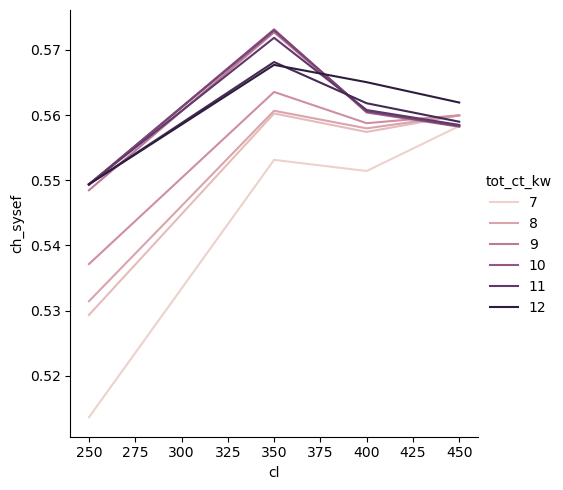

In [ ]:
# graph of lift vs cooling load with hue of 
p = sns.relplot(
    data=df[df['lift']==22], kind="line",
    x="cl", y="ch_sysef",
    hue="tot_ct_kw"
)

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

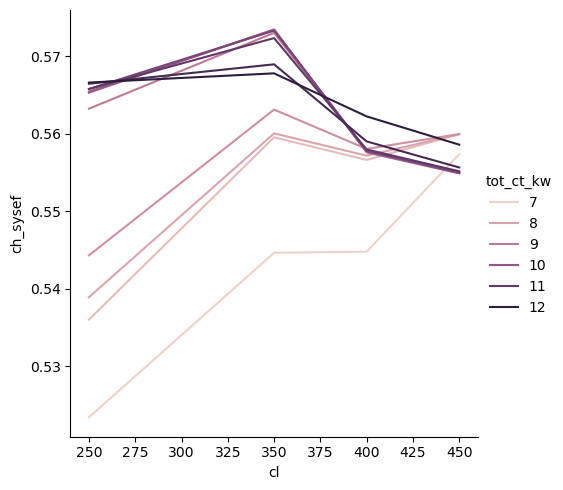

In [ ]:
p = sns.relplot(
    data=df[df['lift']==23], kind="line",
    x="cl", y="ch_sysef",
    hue="tot_ct_kw"
)

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

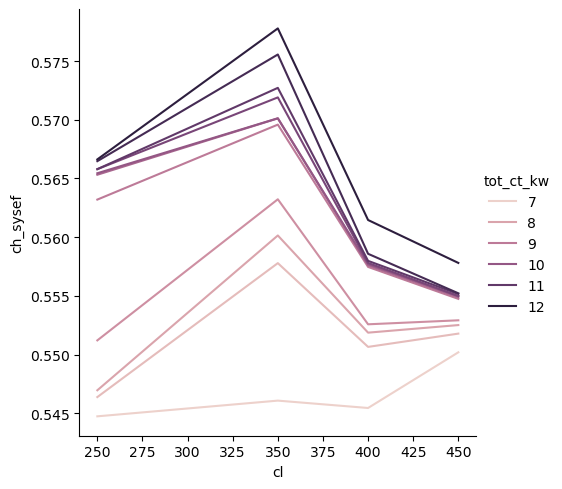

In [ ]:
p = sns.relplot(
    data=df[df['lift']==24], kind="line",
    x="cl", y="ch_sysef",
    hue="tot_ct_kw"
)

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

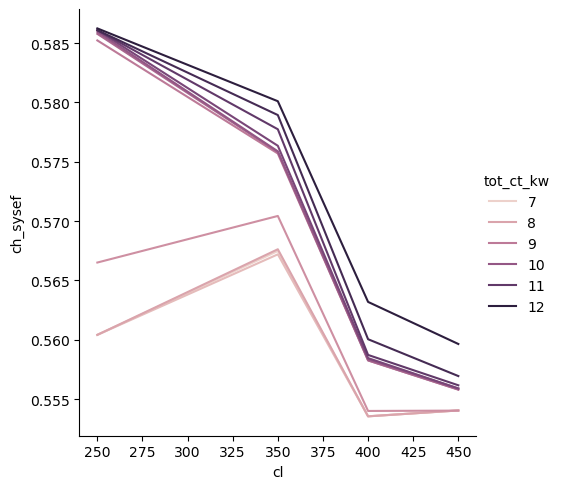

In [ ]:
p = sns.relplot(
    data=df[df['lift']==25], kind="line",
    x="cl", y="ch_sysef",
    hue="tot_ct_kw"
)

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

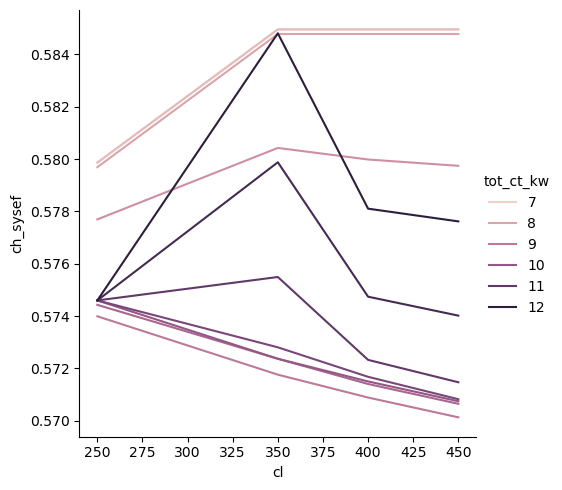

In [ ]:
p = sns.relplot(
    data=df[df['lift']==26], kind="line",
    x="cl", y="ch_sysef",
    hue="tot_ct_kw"
)

In [ ]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [ ]:
X = ch_sysef_df[['lift', 'sys_cl']]
y = ch_sysef_df[['ch_sysef']]
y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

timestamp,12/3/23 10:35,12/3/23 10:36,12/3/23 10:37,12/3/23 10:38,12/3/23 10:39,12/3/23 10:40,12/3/23 10:41,12/3/23 10:42,12/3/23 10:43,12/3/23 10:44,...,23/3/23 20:01,23/3/23 20:02,23/3/23 20:03,23/3/23 20:04,23/3/23 20:05,23/3/23 20:06,23/3/23 20:07,23/3/23 20:08,23/3/23 20:09,23/3/23 20:10
ch_sysef,0.387167,0.308619,0.391576,0.550531,0.46719,0.405483,0.404026,0.776193,0.430923,0.511065,...,0.553528,0.557108,0.562911,0.557318,0.552821,0.554524,0.545478,0.554409,0.560558,0.560833


In [ ]:
no_of_trees = [500, 1000]
min_samples_splits = [1000, 5000, 10000]

parameter_grid = {
    'max_depth': no_of_trees,
    'min_samples_split': min_samples_splits
}

grid_search_2feat = GridSearchCV(
    estimator= RandomForestRegressor(),
    param_grid=parameter_grid,
    cv=3
)

regr = RandomForestRegressor()
grid_search_2feat.fit(X_train, y_train)

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [500, 1000],
                         'min_samples_split': [1000, 5000, 10000]})

In [ ]:
grid_search_2feat.best_params_

{'max_depth': 100, 'min_samples_split': 500}

In [ ]:
X_test.iloc[2]

lift       23.356293
sys_cl    266.424683
Name: 27/5/23 16:29, dtype: float64

In [ ]:
y_test.iloc[2]

ch_sysef    0.553703
Name: 27/5/23 16:29, dtype: float64

In [ ]:
grid_search_2feat.predict([[23.356, 266.42]])

/opt/anaconda3/envs/kaer/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.5298988])